# **Data Preprocessing & Basic EDA**

**Executive Summary**

1. **Missing contains important information** in this dataset tagged players are extremely skilled and worth 4x more on avg, players with missing core observable features eg shooting dribbling, etc are goalies

2. **The target is extremely right skewed** euro valuations are extremely right skewed with a hnadful of players being worth more than the entire rest of the dataset


3. **Key feature properties** Highly multicolinear BUT, they are not additive, they have a plethora of significant interaction effects, as well as nonlinear effects, including distinct threshold like affects on value.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


def load_data(filepath: str) -> pd.DataFrame:
    """Load CSV or Excel file."""
    path = Path(filepath)
    if path.suffix == '.csv':
       return pd.read_csv(filepath, sep=";")

    elif path.suffix in ['.xlsx', '.xls']:
        return pd.read_excel(filepath)
    else:
        raise ValueError(f"Unsupported file type: {path.suffix}")


def get_missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate missing data statistics per column."""
    summary = pd.DataFrame({
        'dtype': df.dtypes.astype(str),
        'missing_count': df.isnull().sum(),
        'missing_pct': (df.isnull().sum() / len(df) * 100).round(2),
        'unique_values': df.nunique(),
    })
    # Add sample values separately to avoid index issues
    summary['sample_values'] = [df[col].dropna().head(3).tolist() for col in df.columns]
    return summary.sort_values('missing_pct', ascending=False)


def plot_missing_bar(df: pd.DataFrame, ax=None):
    """Bar chart of missing percentages by column."""
    missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=True)
    missing_pct = missing_pct[missing_pct > 0]
    
    if missing_pct.empty:
        return None
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, max(4, len(missing_pct) * 0.3)))
    
    colors = ['#2ecc71' if x < 5 else '#f39c12' if x < 20 else '#e74c3c' for x in missing_pct]
    ax.barh(missing_pct.index, missing_pct.values, color=colors)
    ax.set_xlabel('Missing %')
    ax.set_title('Missing Data by Column')
    ax.axvline(x=5, color='gray', linestyle='--', alpha=0.5, label='5%')
    ax.axvline(x=20, color='gray', linestyle=':', alpha=0.5, label='20%')
    
    for i, (idx, val) in enumerate(missing_pct.items()):
        ax.text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=8)
    
    return ax


def plot_missing_matrix(df: pd.DataFrame, ax=None, sample_size=500):
    """Matrix visualization showing missing pattern (white = missing)."""
    # Sample if too large
    if len(df) > sample_size:
        sample_df = df.sample(sample_size, random_state=42).sort_index()
    else:
        sample_df = df
    
    # Only include columns with some missing data
    cols_with_missing = df.columns[df.isnull().any()].tolist()
    if not cols_with_missing:
        return None
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create binary matrix (1 = present, 0 = missing)
    matrix = sample_df[cols_with_missing].notnull().astype(int)
    
    sns.heatmap(matrix.T, cmap=['white', '#3498db'], cbar=False, ax=ax,
                yticklabels=True, xticklabels=False)
    ax.set_title(f'Missing Data Pattern (sample n={len(sample_df)})')
    ax.set_xlabel('Row Index')
    ax.set_ylabel('Column')
    
    return ax


def plot_missing_correlations(df: pd.DataFrame, ax=None):
    """Heatmap of missingness correlations between columns."""
    # Get columns with missing data
    cols_with_missing = df.columns[df.isnull().any()].tolist()
    
    if len(cols_with_missing) < 2:
        return None
    
    # Create missingness indicator matrix
    missing_indicators = df[cols_with_missing].isnull().astype(int)
    corr = missing_indicators.corr()
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
                center=0, ax=ax, vmin=-1, vmax=1)
    ax.set_title('Missingness Correlation\n(Do columns tend to be missing together?)')
    
    return ax


def plot_dtype_breakdown(df: pd.DataFrame, ax=None):
    """Pie chart of data types."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    dtype_counts = df.dtypes.astype(str).value_counts()
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(dtype_counts)))
    
    ax.pie(dtype_counts.values, labels=dtype_counts.index, autopct='%1.0f%%',
           colors=colors, startangle=90)
    ax.set_title('Column Data Types')
    
    return ax


def plot_missing_by_dtype(df: pd.DataFrame, ax=None):
    """Grouped bar showing missing % by data type."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    # Group columns by dtype
    dtype_missing = df.dtypes.astype(str).to_frame('dtype')
    dtype_missing['missing_pct'] = df.isnull().mean() * 100
    
    grouped = dtype_missing.groupby('dtype')['missing_pct'].agg(['mean', 'max', 'count'])
    grouped = grouped.sort_values('mean', ascending=True)
    
    x = np.arange(len(grouped))
    width = 0.35
    
    ax.barh(x - width/2, grouped['mean'], width, label='Mean Missing %', color='#3498db')
    ax.barh(x + width/2, grouped['max'], width, label='Max Missing %', color='#e74c3c', alpha=0.7)
    
    ax.set_yticks(x)
    ax.set_yticklabels([f"{idx}\n(n={int(row['count'])})" for idx, row in grouped.iterrows()])
    ax.set_xlabel('Missing %')
    ax.set_title('Missing Data by Data Type')
    ax.legend()
    
    return ax


def run_diagnostics(filepath: str, output_dir: str = None) -> dict:
    """
    Run full missing data diagnostics.
    
    Returns dict with summary DataFrame and saves plots.
    """
    # Load
    df = load_data(filepath)
    
    # Summary stats
    summary = get_missing_summary(df)
    overall_missing = df.isnull().sum().sum() / df.size * 100
    
    # Print summary
    print(f"\n{'-'*60}")
    print(f"MISSING DATA DIAGNOSTICS")
    print(f"{'-'*60}")
    print(f"Dataset: {filepath}")
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Overall missing: {overall_missing:.2f}%")
    print(f"Complete rows: {df.dropna().shape[0]:,} ({df.dropna().shape[0]/len(df)*100:.1f}%)")
    print(f"\nColumns with missing data: {(df.isnull().any()).sum()} / {df.shape[1]}")
    print(f"{'-'*60}\n")
    
    print(summary.to_string())
    
    # Create figure
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle(f'Missing Data Report: {Path(filepath).name}', fontsize=14, fontweight='bold')
    
    # Layout: 2x3 grid
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: Bar chart (spans 2 columns)
    ax1 = fig.add_subplot(gs[0, :2])
    plot_missing_bar(df, ax=ax1)
    
    # Plot 2: Dtype pie
    ax2 = fig.add_subplot(gs[0, 2])
    plot_dtype_breakdown(df, ax=ax2)
    
    # Plot 3: Missing matrix
    ax3 = fig.add_subplot(gs[1, 0])
    result = plot_missing_matrix(df, ax=ax3)
    if result is None:
        ax3.text(0.5, 0.5, 'No missing data', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Missing Data Pattern')
    
    # Plot 4: Correlation heatmap
    ax4 = fig.add_subplot(gs[1, 1])
    result = plot_missing_correlations(df, ax=ax4)
    if result is None:
        ax4.text(0.5, 0.5, 'Need 2+ columns\nwith missing data', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Missingness Correlation')
    
    # Plot 5: By dtype
    ax5 = fig.add_subplot(gs[1, 2])
    plot_missing_by_dtype(df, ax=ax5)
    
    plt.tight_layout()
    
    return {
        "df": df,
        "summary": summary,
        "overall_missing_pct": overall_missing,
        "figure": fig
    }



------------------------------------------------------------
MISSING DATA DIAGNOSTICS
------------------------------------------------------------
Dataset: ../data/df_players.csv
Shape: 5,969 rows × 21 columns
Overall missing: 6.79%
Complete rows: 710 (11.9%)

Columns with missing data: 7 / 21
------------------------------------------------------------

                             dtype  missing_count  missing_pct  unique_values                                                                     sample_values
player_tags                 object           5259        88.11             65                                                    [#Acrobat, #Dribbler, #Engine]
dribbling                  float64            543         9.10             63                                                                [72.0, 71.0, 69.0]
physic                     float64            543         9.10             54                                                                [43.0, 60.0, 59.0]
pa

/tmp/ipykernel_49903/848475161.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


,dtype,missing_count,missing_pct,unique_values,sample_values
player_tags,object,5259,88.11,65,"[#Acrobat, #Dribbler, #Engine]"
dribbling,float64,543,9.10,63,"[72.0, 71.0, 69.0]"
physic,float64,543,9.10,54,"[43.0, 60.0, 59.0]"
pace,float64,543,9.10,69,"[83.0, 72.0, 75.0]"
passing,float64,543,9.10,66,"[61.0, 65.0, 67.0]"


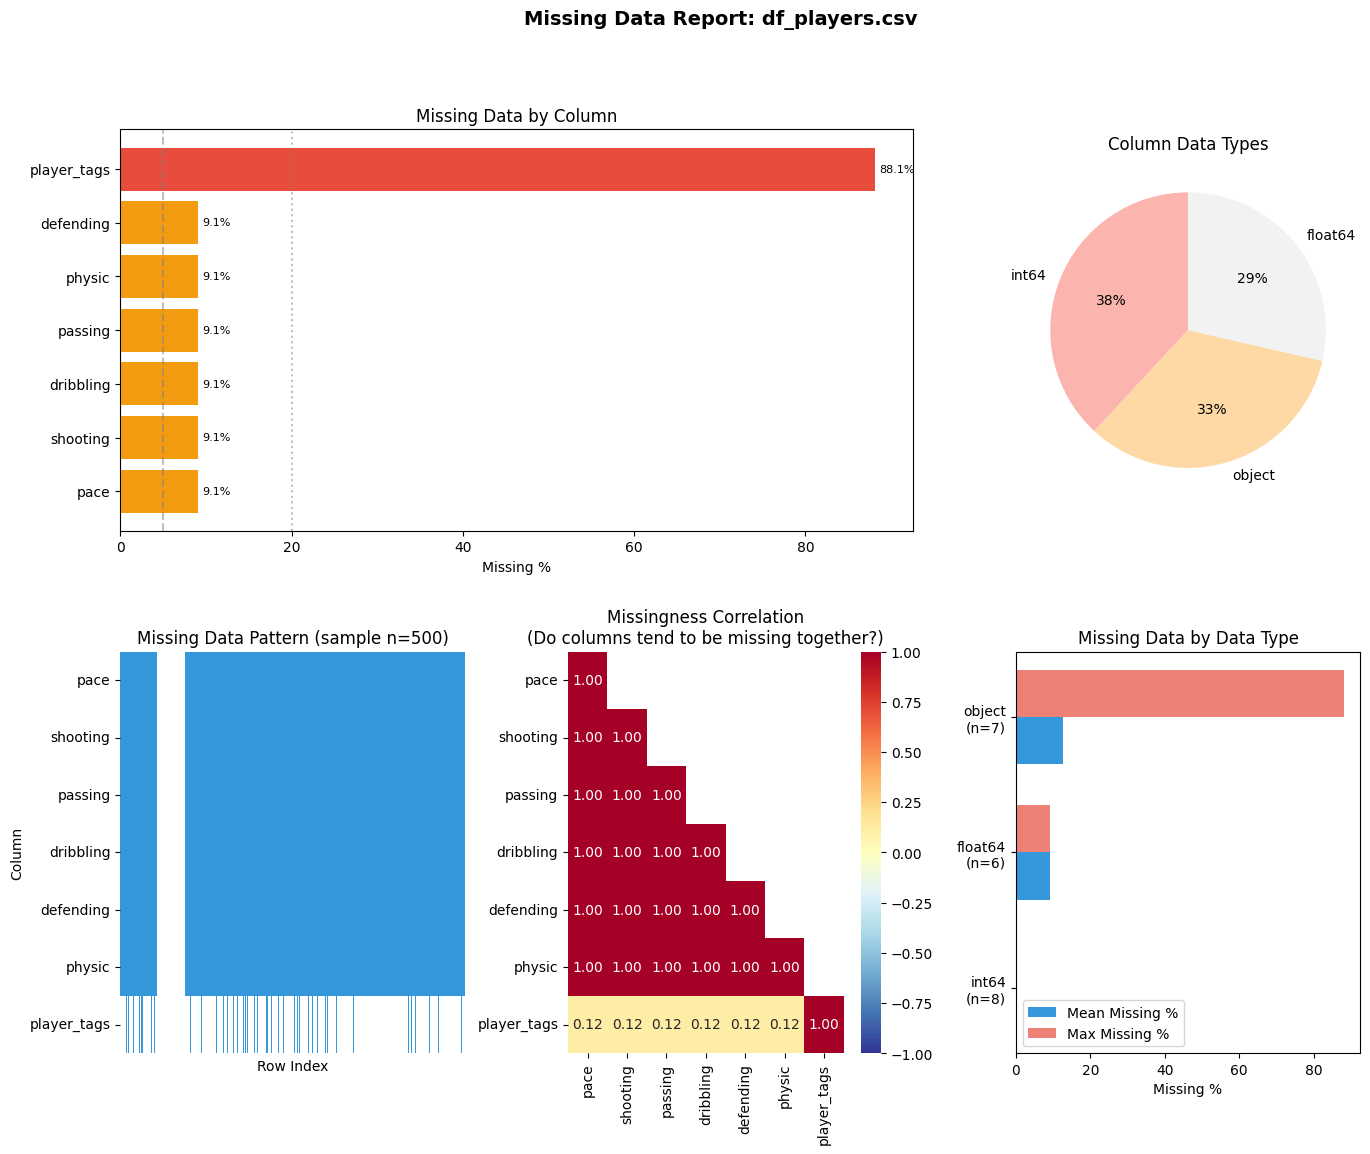

In [2]:

# Run missing-data diagnostics on FIFA players dataset

DATA_PATH = "../data/df_players.csv"

results = run_diagnostics(
    filepath=DATA_PATH,
    output_dir=None  
)


missing_summary = results["summary"]
missing_summary.head()



In [1]:
import pandas as pd

df = pd.read_csv("../data/df_players.csv", sep=";")

for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


core_features = [
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic"
]

missing_core = df[df[core_features].isnull().any(axis=1)]
cols_to_show = [
    "short_name",
    "formation",
    "overall",
    "potential",
    "age",
    "height_cm",
    "weight_kg",
] + core_features

missing_core[cols_to_show].head(10)


Unnamed: 0: 5969 unique values
sofifa_id: 5969 unique values
short_name: 5786 unique values
overall: 46 unique values
potential: 42 unique values
age: 27 unique values
height_cm: 46 unique values
weight_kg: 49 unique values
club_name: 543 unique values
league_name: 46 unique values
club_contract_valid_until: 9 unique values
preferred_foot: 2 unique values
pace: 69 unique values
shooting: 75 unique values
passing: 66 unique values
dribbling: 63 unique values
defending: 74 unique values
physic: 54 unique values
formation: 4 unique values
player_tags: 65 unique values
value_eur: 244 unique values


,short_name,formation,overall,potential,age,height_cm,weight_kg,pace,shooting,passing,dribbling,defending,physic
562,R. Bentancur,GK,65,65,32,184,78,NaN,NaN,NaN,NaN,NaN,NaN
563,J. Devecchi,GK,70,73,25,188,83,NaN,NaN,NaN,NaN,NaN,NaN
564,F. Al Qarni,GK,65,66,29,184,86,NaN,NaN,NaN,NaN,NaN,NaN
565,Daniel Figueira,GK,69,77,22,189,82,NaN,NaN,NaN,NaN,NaN,NaN
566,M. Paes,GK,68,77,23,191,82,NaN,NaN,NaN,NaN,NaN,NaN
567,A. Leitner,GK,68,70,27,184,72,NaN,NaN,NaN,NaN,NaN,NaN
568,J. Hart,GK,74,74,34,196,91,NaN,NaN,NaN,NaN,NaN,NaN
569,Unai Simón,GK,82,86,24,190,89,NaN,NaN,NaN,NaN,NaN,NaN
570,Wu Yan,GK,68,68,32,191,82,NaN,NaN,NaN,NaN,NaN,NaN
571,B. Costil,GK,79,79,33,187,82,NaN,NaN,NaN,NaN,NaN,NaN


### Rationale for Separating Goalkeepers and Outfield Players

The missingness observed in core outfield attributes (pace, shooting, passing, dribbling, defending, physic) is not random. These values are consistently missing only for players whose formation is goalkeeper.

This indicates informative NMAR (Not Missing At Random) missingness: the absence of these metrics reflects player role rather than data quality. Goalkeepers do not logically possess outfield skill ratings.

As a result, goalkeepers and outfield players are analysed as separate groups. This avoids artificial imputation, preserves domain meaning, and leads to clearer and more interpretable valuation analysis.


### Are player tags missingness informative?


STAR FACTOR TEST: PLAYER TAGS
----------------------------------------
       group    n  mean_value_eur  median_value_eur
   With tags  584    1.161688e+07         3400000.0
Without tags 5057    2.891629e+06         1400000.0

Welch t-test:
t-statistic = 10.19
p-value     = 1.421e-22
Cohen's d   = 1.03


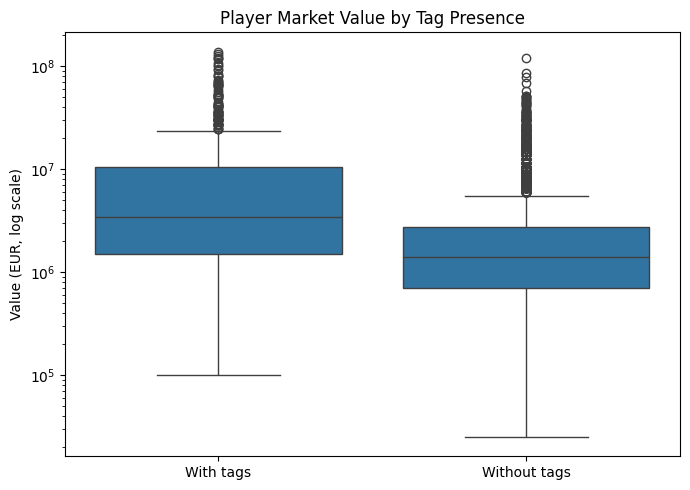

In [ ]:

# Star factor test: Players with tags vs without tags


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Ensure value is numeric
df["value_eur"] = pd.to_numeric(df["value_eur"], errors="coerce")

# Define groups
with_tags = df.loc[df["player_tags"].notna(), "value_eur"].dropna()
without_tags = df.loc[df["player_tags"].isna(), "value_eur"].dropna()

# Summary stats
summary = pd.DataFrame({
    "group": ["With tags", "Without tags"],
    "n": [len(with_tags), len(without_tags)],
    "mean_value_eur": [with_tags.mean(), without_tags.mean()],
    "median_value_eur": [with_tags.median(), without_tags.median()]
})

# Welch t-test
t_stat, p_value = stats.ttest_ind(with_tags, without_tags, equal_var=False)

# Effect size (Cohen's d)
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(
        ((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / (nx + ny - 2)
    )
    return (x.mean() - y.mean()) / pooled_std

d = cohens_d(with_tags, without_tags)

# Print results
print("\nSTAR FACTOR TEST: PLAYER TAGS\n" + "-"*40)
print(summary.to_string(index=False))
print("\nWelch t-test:")
print(f"t-statistic = {t_stat:.2f}")
print(f"p-value     = {p_value:.4g}")
print(f"Cohen's d   = {d:.2f}")

# Prepare data for plotting
plot_df = pd.DataFrame({
    "value_eur": pd.concat([with_tags, without_tags]),
    "group": (["With tags"] * len(with_tags)) + (["Without tags"] * len(without_tags))
})

# Visual: boxplot with log scale (values are heavy-tailed)
plt.figure(figsize=(7, 5))
sns.boxplot(data=plot_df, x="group", y="value_eur")
plt.yscale("log")
plt.title("Player Market Value by Tag Presence")
plt.ylabel("Value (EUR, log scale)")
plt.xlabel("")
plt.tight_layout()
plt.show()




Players with tags are much more valuable than players without tags.

The average tagged player is worth ~4× more, and even the median tagged player is worth over twice as much.

The difference is not marginal — the effect size (Cohen’s d ≈ 1) is very large, indicating a strong separation between the two groups.

Tags likely act as a proxy for star power or reputation, capturing visibility and market appeal beyond raw performance alone.

This is a strong association, not a causal claim, but it clearly aligns with a meaningful valuation premium.

--- 

Clean resulting showing that players who have earned tags/nicknames are usually worth more. This gives insight into a kind of star factor to model.
This gives us to encoding a "Star_Player" binary tag.

But then this raises a question are certain kinds of stars better than other stars in terms of valuation what are the archetypes of star player and how can this translate to value.



In [ ]:
#intuition -> WHAT MAKES A STAR? -> CAN WE PREDICT FUTURE STARS
#identify STAR players, identify clusters inside? what kind of players can become stars? how does this translate to valuation.


### **CLEANING PLAN**

Missingness in this dataset is highly informative so it's less of eliminating missingness and more of translating missiness into features that convey info and managing it accordingly.

1. Divide GK and Outfielders into two seperate datasets.
   - Different valuation metrics are highly probable here
   - GK have 100% missingness in a large section of features, a model or framework to try and value both GKs and Outfielders the same will lead to limited clarity hence two seperate frameworks will be proposed

2. Tag Players as STARS if they have a player_tag. 
   - Following tagging I will cluster inside of STARs to identify if they demonstrate meaningful seperation it will be interesting to see what kind of players can become stars
   - It will also be interesting to see differences in valuations within the STAR group based on cluster alongside this it will give info into whether the nicknames convey any information e.g do aggressive sounding tags like "engine" "acrobat" convey a higher price premium than passive tags like "The Wall" 

In [5]:
# Split dataset by role
gk_df = df[df["formation"] == "GK"].copy()
outfield_df = df[df["formation"] != "GK"].copy()

# Sanity checks
print("DF shapes")
print(gk_df.shape, outfield_df.shape)


# Confirm missingness logic holds
outfield_df[["pace", "shooting", "passing", "dribbling", "defending", "physic"]].isnull().sum()


DF shapes
(543, 21) (5426, 21)


pace         0
shooting     0
passing      0
dribbling    0
defending    0
physic       0
dtype: int64

In [20]:
# Create star indicator (1 = star, 0 = non-star)
outfield_df["is_star"] = outfield_df["player_tags"].notna().astype(int)
gk_df["is_star"] = gk_df["player_tags"].notna().astype(int)

# Proportions
outfield_star_rate = outfield_df["is_star"].mean()
gk_star_rate = gk_df["is_star"].mean()

print(outfield_star_rate, gk_star_rate)

# Save datasets
outfield_df.to_csv("../data/outfield_players.csv", index=False)
gk_df.to_csv("../data/gk_players.csv", index=False)

# (Optional) also save star-only subsets
outfield_df[outfield_df["is_star"] == 1].to_csv(
    "../data/outfield_star_players.csv", index=False
)


0.13085145595281975 0.0


# **Basic EDA**
Is this data nonsense ? 

- test distributions
- outliers etc (are outliers informative?)

In [21]:
import pandas as pd
import numpy as np
from scipy.stats import skew

df["value_eur"] = (
    df["value_eur"]
    .astype(str)
    .str.replace(",", ".", regex=False)
)

df["value_eur"] = pd.to_numeric(df["value_eur"], errors="coerce")


def eda_sanity_scan(
    df,
    target="value_eur",
    skill_bounds=(0, 100),
    id_keywords=("id", "unnamed"),
    corr_warn_low=0.02,
    corr_warn_high=0.9
):

    report = []

    for col in df.columns:

        s = df[col]

        col_info = {
            "feature": col,
            "dtype": s.dtype,
            "n_unique": s.nunique(),
            "missing_pct": round(s.isna().mean() * 100, 2),
            "flags": []
        }

        if any(k in col.lower() for k in id_keywords):
            col_info["flags"].append("Identifier-like column")

        if s.nunique() <= 1:
            col_info["flags"].append("Constant feature")

        if s.nunique() < 5 and pd.api.types.is_numeric_dtype(s):
            col_info["flags"].append("Very low cardinality numeric")

        if pd.api.types.is_numeric_dtype(s):

            s_clean = s.dropna()

            if (s_clean < 0).any():
                col_info["flags"].append("Contains negative values")

            if col.lower() in [
                "pace", "shooting", "passing",
                "dribbling", "defending", "physic"
            ]:
                lo, hi = skill_bounds
                if (s_clean < lo).any() or (s_clean > hi).any():
                    col_info["flags"].append("Outside expected 0–100 bounds")

            if len(s_clean) > 20:
                sk = skew(s_clean)
                col_info["skew"] = round(sk, 2)
                if abs(sk) > 2:
                    col_info["flags"].append("Highly skewed distribution")

            if col != target and target in df.columns:

                paired = pd.concat([s, df[target]], axis=1).dropna()

                if len(paired) > 30:
                    corr = paired.iloc[:, 0].corr(paired.iloc[:, 1])
                    col_info["corr_with_value"] = round(corr, 3)

                    if abs(corr) < corr_warn_low:
                        col_info["flags"].append("Near-zero relationship with value")

                    if abs(corr) > corr_warn_high:
                        col_info["flags"].append("Suspiciously strong correlation")

        if col_info["missing_pct"] > 20:
            col_info["flags"].append("High missingness (>20%)")

        if 0 < col_info["missing_pct"] < 1:
            col_info["flags"].append("Sparse missingness (check encoding)")

        report.append(col_info)

    return (
        pd.DataFrame(report)
        .sort_values("missing_pct", ascending=False)
        .reset_index(drop=True)
    )


eda_report = eda_sanity_scan(df)
eda_report


,feature,dtype,n_unique,missing_pct,flags,skew,corr_with_value
0,player_tags,object,65,88.11,[High missingness (>20%)],NaN,NaN
1,defending,float64,74,9.10,[],-0.57,0.127
2,shooting,float64,75,9.10,[],-0.34,0.272
3,passing,float64,66,9.10,[],-0.17,0.394
4,pace,float64,69,9.10,[],-0.62,0.167
5,dribbling,float64,63,9.10,[],-0.44,0.392
6,physic,float64,54,9.10,[],-0.55,0.185
7,value_eur,float64,179,5.50,[Highly skewed distribution],7.14,NaN
8,log_value,float64,179,5.50,[],0.45,0.670
9,potential,int64,42,0.00,[],0.23,0.573


In [10]:
#highly skewed target so log scaling
df["log_value"] = np.log10(df["value_eur"])
#rechecking cors
corrs = (
    df.select_dtypes("number")
      .corr()["log_value"]
      .sort_values(ascending=False)
)
corrs

log_value                    1.000000
potential                    0.891531
overall                      0.875743
value_eur                    0.670390
dribbling                    0.619557
passing                      0.589970
shooting                     0.411233
club_contract_valid_until    0.374111
pace                         0.295183
physic                       0.261864
defending                    0.174003
Unnamed: 0                   0.045826
weight_kg                    0.000727
height_cm                   -0.003884
sofifa_id                   -0.051511
age                         -0.188407
Name: log_value, dtype: float64

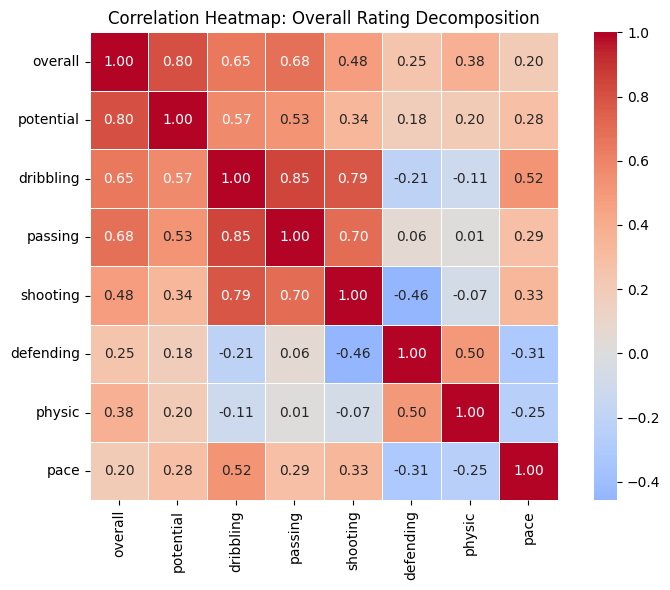

In [15]:

import matplotlib.pyplot as plt
import seaborn as sns

cols = ["overall", "potential", "dribbling", "passing", "shooting", "defending", "physic", "pace"]

corr = df[cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)

plt.title("Correlation Heatmap: Overall Rating Decomposition")
plt.tight_layout()
plt.show()



### interaction effects test


In [26]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# interaction test configuration
SKILLS = [
    "dribbling",
    "passing",
    "shooting",
    "pace",
    "physic",
    "defending",
    "age",
    "overall",
    "potential"# not a skill but important to study as a modulator of price
]

TARGET = "log_value"

# prepare data
df_int = df.copy()
df_int["log_value"] = np.log10(df_int["value_eur"])

# standardise skills for comparable coefficients
for s in SKILLS:
    df_int[f"{s}_z"] = (
        (df_int[s] - df_int[s].mean()) / df_int[s].std()
    )

# run all pairwise interaction regressions
results = []

for s1, s2 in combinations(SKILLS, 2):

    formula = f"{TARGET} ~ {s1}_z + {s2}_z + {s1}_z:{s2}_z"
    model = smf.ols(formula, data=df_int).fit()

    results.append({
        "skill_1": s1,
        "skill_2": s2,
        "interaction_coef": model.params[f"{s1}_z:{s2}_z"],
        "interaction_p": model.pvalues[f"{s1}_z:{s2}_z"],
        "r2": model.rsquared,
        "n_obs": int(model.nobs)
    })

interaction_df = pd.DataFrame(results)

# multiple testing correction (FDR)
interaction_df["p_fdr"] = multipletests(
    interaction_df["interaction_p"],
    method="fdr_bh"
)[1]

interaction_df["significant_5pct"] = interaction_df["interaction_p"] < 0.05
interaction_df["significant_fdr"] = interaction_df["p_fdr"] < 0.05

# rank by economic magnitude
interaction_df["abs_effect"] = interaction_df["interaction_coef"].abs()

interaction_df = interaction_df.sort_values(
    ["significant_fdr", "abs_effect"],
    ascending=[False, False]
)

interaction_df


,skill_1,skill_2,interaction_coef,interaction_p,r2,n_obs,p_fdr,significant_5pct,significant_fdr,abs_effect
17,shooting,defending,-0.281175,5.402120e-275,0.486070,5131,1.944763e-273,True,True,0.281175
4,dribbling,defending,-0.155459,2.056955e-133,0.546845,5131,1.851259e-132,True,True,0.155459
1,dribbling,shooting,0.152679,2.459123e-190,0.489873,5131,4.426422e-189,True,True,0.152679
0,dribbling,passing,0.117036,8.024539e-146,0.473250,5131,9.629447e-145,True,True,0.117036
9,passing,pace,0.104727,4.352289e-71,0.406642,5131,1.740916e-70,True,True,0.104727
8,passing,shooting,0.095134,9.832516e-69,0.386069,5131,3.539706e-68,True,True,0.095134
2,dribbling,pace,0.091938,7.818873e-66,0.418793,5131,2.558904e-65,True,True,0.091938
26,physic,defending,0.087554,4.432905e-39,0.101530,5131,9.974035e-39,True,True,0.087554
34,age,potential,0.079437,4.192182e-133,0.822185,5641,3.018371e-132,True,True,0.079437
15,shooting,pace,0.070883,7.301850e-27,0.216984,5131,1.251746e-26,True,True,0.070883


- **Strong interaction effects:** Skill combinations exhibit large, highly significant non-additive effects, confirming that player value depends on joint skill bundles rather than isolated attributes.

- **Role coherence matters:** Positive interactions cluster among complementary attacking skills (e.g., dribbling × shooting, passing × pace), while strong negative interactions arise between offensive and defensive traits, indicating market penalties for mixed-role profiles.

- **Archetype-based pricing:** The presence of both large positive and negative interactions shows that valuation is driven by proximity to coherent player archetypes, not linear accumulation of skills.


### linearity testing

In [25]:
#linear/nonlinear effect test suite

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

SKILLS = [
    "dribbling",
    "passing",
    "shooting",
    "pace",
    "physic",
    "defending",
    "age",
    "potential",
    "overall", #not a skill but important to study as a modulator of price
]  

TARGET = "log_value"

#clean data (basiclly just means removing goalies)

df_thr = df.copy()

df_thr["log_value"] = np.log10(df_thr["value_eur"])

df_thr = df_thr.dropna(
    subset=SKILLS + ["log_value"]
).reset_index(drop=True)

results = []

#main loop
for skill in SKILLS:

    x = df_thr[skill].values

 #linear effects
    lin_model = smf.ols(
        f"{TARGET} ~ {skill}",
        data=df_thr
    ).fit()

 #quadratic
    df_thr[f"{skill}_sq"] = df_thr[skill] ** 2

    quad_model = smf.ols(
        f"{TARGET} ~ {skill} + {skill}_sq",
        data=df_thr
    ).fit()

 # piecewise effects
    thresholds = np.percentile(x, [50, 75, 90])

    best_r2 = lin_model.rsquared
    best_thr = None

    for t in thresholds:

        hinge = np.maximum(0, x - t)

        df_tmp = df_thr.copy()
        df_tmp["hinge"] = hinge

        pw_model = smf.ols(
            f"{TARGET} ~ {skill} + hinge",
            data=df_tmp
        ).fit()

        if pw_model.rsquared > best_r2:
            best_r2 = pw_model.rsquared
            best_thr = t

 #storage object
    results.append({
        "skill": skill,
        "linear_r2": lin_model.rsquared,
        "quadratic_r2": quad_model.rsquared,
        "piecewise_r2": best_r2,
        "delta_quad": quad_model.rsquared - lin_model.rsquared,
        "delta_piecewise": best_r2 - lin_model.rsquared,
        "threshold_rating": best_thr,
        "linear_p": lin_model.pvalues[skill],
        "quad_sq_p": quad_model.pvalues[f"{skill}_sq"]
    })

threshold_df = pd.DataFrame(results).sort_values(
    "delta_piecewise",
    ascending=False
)

threshold_df


,skill,linear_r2,quadratic_r2,piecewise_r2,delta_quad,delta_piecewise,threshold_rating,linear_p,quad_sq_p
5,defending,0.030277,0.166367,0.260021,0.136090,0.229743,61.0,3.643731e-36,1.224870e-170
0,dribbling,0.383851,0.475993,0.484234,0.092142,0.100383,66.0,0.000000e+00,1.214154e-182
2,shooting,0.169112,0.233899,0.258870,0.064786,0.089758,65.0,1.254582e-208,1.597468e-92
1,passing,0.348065,0.388817,0.391874,0.040752,0.043809,67.0,0.000000e+00,5.901879e-74
6,age,0.022988,0.047518,0.044210,0.024531,0.021222,30.0,9.140182e-28,3.378001e-30
4,physic,0.068573,0.086131,0.089660,0.017558,0.021087,74.0,3.238350e-81,5.172112e-23
8,overall,0.813009,0.828697,0.830868,0.015687,0.017858,73.0,0.000000e+00,1.029414e-99
3,pace,0.087133,0.092044,0.092816,0.004910,0.005683,70.0,1.098261e-103,1.449322e-07
7,potential,0.811813,0.813884,0.815050,0.002071,0.003236,80.0,0.000000e+00,4.982752e-14


- **Clear non-linearity:** Piecewise and quadratic models consistently outperform linear specifications, indicating that player value does not increase proportionally with skill levels.

- **Threshold effects:** Several attributes—especially dribbling and shooting—exhibit sharp valuation breakpoints around the mid-60s rating range, after which marginal returns rise rapidly.

- **Skill-type asymmetry:** Technical skills show strong threshold-driven pricing, while physical attributes display weaker, largely linear effects and mainly act as complements rather than primary value drivers.
